<a href="https://colab.research.google.com/github/Bishop81285/wsi_neuro_model_classification/blob/main/wsi_model_classification_(%D0%93%D1%83%D1%80%D1%8C%D1%8F%D0%BD%D0%BE%D0%B2_%D0%90).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Практическое задание №1**

Установка необходимых пакетов:

In [1]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


Монтирование Вашего Google Drive к текущему окружению:

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [3]:
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1Khe_lqHBVxTfjUG66BicYcWu7SbRY0rv',
    'train_small': '1c91fkw22rHGBjMahrIRL0VBF02_uueHj',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1VXcfHZcl_9o0VQWnXrWogw7Sm8uJQ98L',
    'test_small': '1zcrJSbLqg8CcId60UfKcowlJ6d0Q0wvo',
    'test_tiny': '1SEeXWswVXBUv5aqGZ6u-CHNWZ7-AdGQQ'
}

Импорт необходимых зависимостей:

In [4]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=93cc0fc672f31115d5e5d2a1e3a2235d14f60090a06da1c40b7fd0f7a5691b14
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [5]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import gdown
import torch
import torch.nn as nn
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, Subset
from itertools import islice
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [6]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def __len__(self):
        return self.n_files

    def __getitem__(self, idx):
        img, label = self.images[idx], self.labels[idx]
        img_tensor = self.preprocess_image(img)
        if img_tensor.shape != (3, 224, 224):
          raise ValueError(f"Неправильная размерность тензора: {img_tensor.shape}")
        return img_tensor, label

    def preprocess_image(self, img):
        img = Image.fromarray(img)

        preprocess = transforms.Compose([
            transforms.Resize((224, 224)),  # Изменение размера изображения
            transforms.RandomHorizontalFlip(),  # Случайное горизонтальное отражение
            transforms.RandomRotation(10),  # Случайный поворот на 10 градусов
            transforms.ToTensor(),  # Преобразование в тензор PyTorch
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
        ])
        return preprocess(img)

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [7]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [8]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


In [9]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        # Загрузка предобученной модели EfficientNet
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b1')

        # Настройка выходного слоя для 9 классов
        num_ftrs = self.efficientnet._fc.in_features
        self.efficientnet._fc = nn.Linear(num_ftrs, 9)

    def forward(self, x):
        return self.efficientnet(x)

    def preprocess_image(self, img: Image):
        preprocess = transforms.Compose([
            transforms.ToTensor(),  # Преобразование в тензор PyTorch
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
        ])

        img_tensor = preprocess(img)
        img_tensor = img_tensor.unsqueeze(0)  # Добавление дополнительной размерности для батча
        return img_tensor

    def save(self, filename):
        filepath = f'/content/drive/My Drive/problem_1_wsi/{filename}'
        torch.save(self.state_dict(), filepath)
        print(f'Model saved to {filepath}')

    def load(self, google_drive_id):
        url = f'https://drive.google.com/uc?id={google_drive_id}'
        output_path = '/content/best_model.pth'
        gdown.download(url, output_path, quiet=False)

        self.load_state_dict(torch.load(output_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
        print(f'Model loaded from {output_path}')

    def validate(self, val_loader, criterion):
        self.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
          for images, labels in val_loader:
              images, labels = images.to(device), labels.to(device)
              outputs = self(images)
              loss = criterion(outputs, labels)

              val_loss += loss.item()
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = correct / total
        print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
        return val_loss, val_accuracy

    def train_model(self, train_loader, val_loader, epochs=10, learning_rate=1e-4):
      early_stopping = EarlyStopping(patience=3, min_delta=0.001)
      self.train()  # Установка модели в режим обучения
      save_interval = 5

      # Инициализация оптимизатора и функции потерь
      optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-5)
      criterion = nn.CrossEntropyLoss()

      # Списки для сохранения истории обучения
      history = {
          'train_loss': [],
          'train_acc': [],
          'val_loss': [],
          'val_acc': []
      }

      for epoch in range(epochs):
          running_loss = 0.0
          correct_predictions = 0
          total_predictions = 0
          for i, (images, labels) in enumerate(train_loader, 0):
              images, labels = images.to(device), labels.to(device)

              optimizer.zero_grad()  # Обнуление градиентов
              outputs = self(images)  # Прямой проход
              loss = criterion(outputs, labels)  # Расчет потерь
              loss.backward()  # Обратный проход
              optimizer.step()  # Обновление весов

              # Статистика
              running_loss += loss.item()
              _, predicted = torch.max(outputs.data, 1)
              total_predictions += labels.size(0)
              correct_predictions += (predicted == labels).sum().item()

              # Печать статистики каждые 100 батчей
              if i % 100 == 99:
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
                running_loss = 0.0

          # Проведение валидации после каждой эпохи
          val_loss, val_acc = self.validate(val_loader, criterion)

          # Печать статистики по завершении эпохи
          epoch_loss = running_loss / len(train_loader)
          epoch_acc = correct_predictions / total_predictions
          print(f'Epoch {epoch + 1} completed: Loss: {epoch_loss}, Accuracy: {epoch_acc}')

          # Опционально: сохранение модели
          if epoch % save_interval == 0:
              self.save(f'model_epoch_{epoch + 1}.pt')

          history['train_loss'].append(epoch_loss)
          history['train_acc'].append(epoch_acc)
          history['val_loss'].append(val_loss)
          history['val_acc'].append(val_acc)

          # Вызов Early Stopping
          early_stopping(val_loss)
          if early_stopping.early_stop:
            print("Early stopping")
            break


    def test_on_dataset(self, dataloader, limit=None):
      self.eval()  # Перевод модели в режим оценки
      predictions = []
      true_labels = []
      probabilities = []

      total_batches = len(dataloader)
      batches_to_process = total_batches if not limit else int(total_batches * limit)

      with torch.no_grad():  # Отключение расчета градиентов
        for i, (images, labels) in enumerate(dataloader):
            if i >= batches_to_process:
                break

            images, labels = images.to(device), labels.to(device)  # Перемещение изображений на GPU
            outputs = self(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            probs = F.softmax(outputs, dim=1)
            probabilities.extend(probs.cpu().numpy())

            # Логирование для каждого батча
            print(f'Batch {i + 1}/{total_batches}: Processed')

      return predictions, true_labels, probabilities


    def test_on_image(self, img: np.ndarray):
      with torch.no_grad():  # Отключение расчета градиентов
          # Преобразование изображения в тензор и выполнение необходимой предобработки
          img_tensor = self.preprocess_image(img).to(device)  # Перемещение на GPU после предобработки
          outputs = self(img_tensor)
          # Получение индекса с максимальным значением в выходных данных (предсказание класса)
          _, prediction = torch.max(outputs, 1)
          return prediction.item()



---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений.

In [10]:
def prepare_data_loaders(dataset, validation_split=0.1, batch_size=64):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=validation_split)
    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [11]:
d_train = Dataset('train')
d_test = Dataset('test')

train_loader, val_loader = prepare_data_loaders(d_train)
test_loader = DataLoader(d_test, batch_size=64, shuffle=False)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1Khe_lqHBVxTfjUG66BicYcWu7SbRY0rv
To: /content/train.npz
100%|██████████| 2.10G/2.10G [00:17<00:00, 119MB/s]


Loading dataset train from npz.
Done. Dataset train consists of 18000 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1VXcfHZcl_9o0VQWnXrWogw7Sm8uJQ98L
To: /content/test.npz
100%|██████████| 525M/525M [00:04<00:00, 105MB/s]


Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


**Обучение модели**

In [12]:
if torch.cuda.is_available():
    print("GPU is available.")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU instead.")
    device = torch.device("cpu")

model = Model().to(device)
if not EVALUATE_ONLY:
    history = model.train_model(train_loader, val_loader)
    model.save('best_model.pth')
else:
    model.load('1-IyWRw2WYwA9lOWb_NsgIZ_taEX_F0py')

GPU is available.


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 79.3MB/s]


Loaded pretrained weights for efficientnet-b1
Epoch 1, Batch 100, Loss: 0.9838434848189354
Epoch 1, Batch 200, Loss: 0.21926608938723802
Validation Loss: 0.07844773541879037, Validation Accuracy: 0.975
Epoch 1 completed: Loss: 0.028181120929286235, Accuracy: 0.8815432098765432
Model saved to /content/drive/My Drive/problem_1_wsi/model_epoch_1.pt
Epoch 2, Batch 100, Loss: 0.1065952978655696
Epoch 2, Batch 200, Loss: 0.08359032892156393
Validation Loss: 0.08479949812693842, Validation Accuracy: 0.9716666666666667
Epoch 2 completed: Loss: 0.025737986954911724, Accuracy: 0.9729629629629629
Epoch 3, Batch 100, Loss: 0.05200247513595969
Epoch 3, Batch 200, Loss: 0.05780982791213319
Validation Loss: 0.05856922292752705, Validation Accuracy: 0.9822222222222222
Epoch 3 completed: Loss: 0.02219986046231755, Accuracy: 0.9820987654320987
Epoch 4, Batch 100, Loss: 0.033812758321873845
Epoch 4, Batch 200, Loss: 0.03140236609149724
Validation Loss: 0.04387213306999284, Validation Accuracy: 0.98333333

**Визуализация результатов обучения**

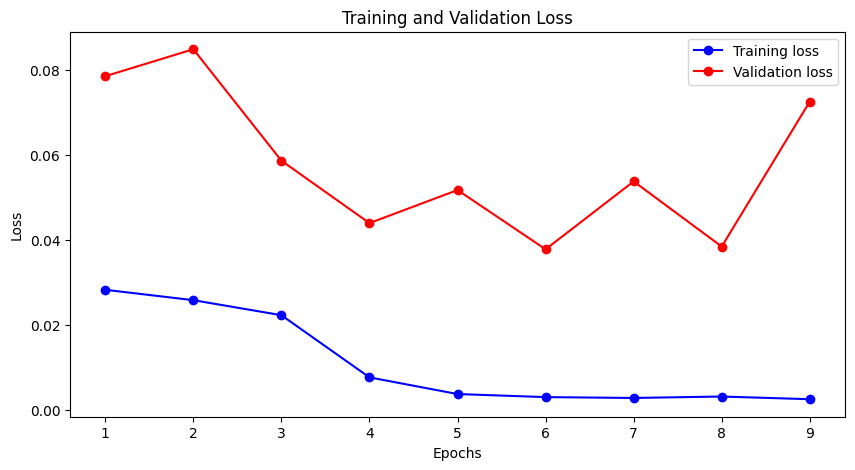

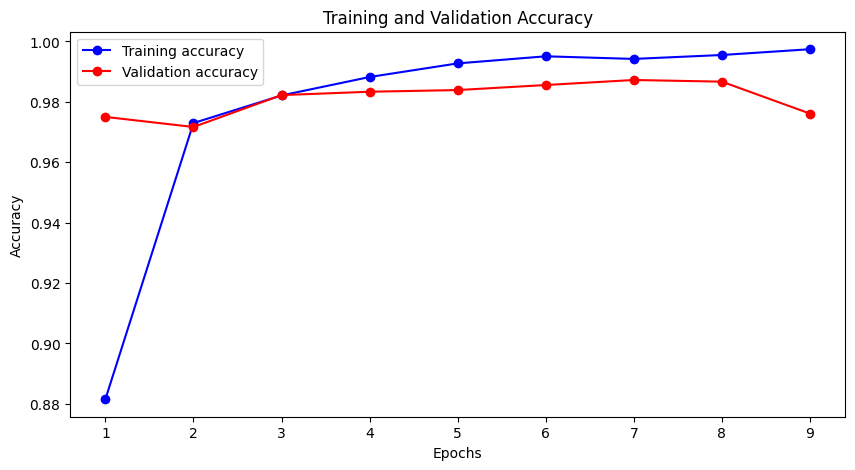

In [26]:
# График потерь
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Пример тестирования модели на части набора данных:

In [14]:
model.load('1-IyWRw2WYwA9lOWb_NsgIZ_taEX_F0py')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1-IyWRw2WYwA9lOWb_NsgIZ_taEX_F0py
From (redirected): https://drive.google.com/uc?id=1-IyWRw2WYwA9lOWb_NsgIZ_taEX_F0py&confirm=t&uuid=13911074-c5e4-4585-aa8c-2350bedc8a30
To: /content/best_model.pth
100%|██████████| 26.5M/26.5M [00:00<00:00, 57.0MB/s]


Model loaded from /content/best_model.pth


In [27]:
# evaluating model on 10% of test dataset
pred_1, true_labels_1, prob_1 = model.test_on_dataset(test_loader, limit=0.1)

Metrics.print_all(true_labels_1, pred_1, '10% of test')

Batch 1/71: Processed
Batch 2/71: Processed
Batch 3/71: Processed
Batch 4/71: Processed
Batch 5/71: Processed
Batch 6/71: Processed
Batch 7/71: Processed
metrics for 10% of test:
	 accuracy 0.9978:
	 balanced accuracy 0.9978:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Пример тестирования модели на полном наборе данных:

In [28]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2, true_labels_2, prob_2 = model.test_on_dataset(test_loader)  # Использование DataLoader

    Metrics.print_all(true_labels_2, pred_2, 'full test')


Batch 1/71: Processed
Batch 2/71: Processed
Batch 3/71: Processed
Batch 4/71: Processed
Batch 5/71: Processed
Batch 6/71: Processed
Batch 7/71: Processed
Batch 8/71: Processed
Batch 9/71: Processed
Batch 10/71: Processed
Batch 11/71: Processed
Batch 12/71: Processed
Batch 13/71: Processed
Batch 14/71: Processed
Batch 15/71: Processed
Batch 16/71: Processed
Batch 17/71: Processed
Batch 18/71: Processed
Batch 19/71: Processed
Batch 20/71: Processed
Batch 21/71: Processed
Batch 22/71: Processed
Batch 23/71: Processed
Batch 24/71: Processed
Batch 25/71: Processed
Batch 26/71: Processed
Batch 27/71: Processed
Batch 28/71: Processed
Batch 29/71: Processed
Batch 30/71: Processed
Batch 31/71: Processed
Batch 32/71: Processed
Batch 33/71: Processed
Batch 34/71: Processed
Batch 35/71: Processed
Batch 36/71: Processed
Batch 37/71: Processed
Batch 38/71: Processed
Batch 39/71: Processed
Batch 40/71: Processed
Batch 41/71: Processed
Batch 42/71: Processed
Batch 43/71: Processed
Batch 44/71: Process

**Сохранение результатов модели в CSV**

In [29]:
def save_test_results(predictions, true_labels, probabilities, file_name):
    # Сохранение результатов в CSV
    results_df = pd.DataFrame({'TrueLabel': true_labels, 'Prediction': predictions, 'Probability': probabilities})
    results_df.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}")


save_test_results(pred_2, true_labels_2, prob_2, 'test_results.csv')

Results saved to test_results.csv


**Визуализация результатов тестирования на полном наборе**

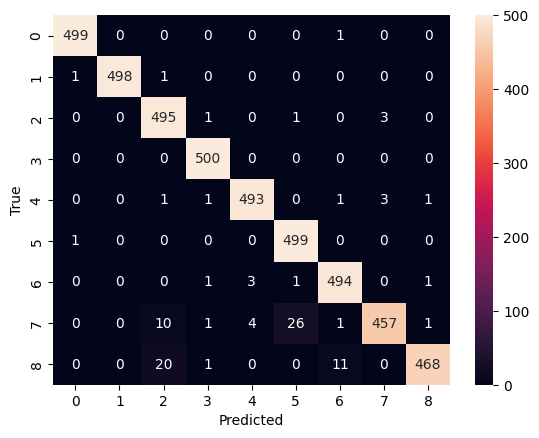

In [30]:
# Построение матрицы ошибок
cm = confusion_matrix(true_labels_2, pred_2)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [31]:
# Расчет чувствительности и специфичности для каждого класса
sensitivity = []
specificity = []

num_classes = cm.shape[0]

for i in range(num_classes):
    true_positive = cm[i, i]
    false_positive = sum(cm[:, i]) - true_positive
    false_negative = sum(cm[i, :]) - true_positive
    true_negative = sum(sum(cm)) - (true_positive + false_positive + false_negative)

    sens = true_positive / (true_positive + false_negative)
    spec = true_negative / (true_negative + false_positive)

    sensitivity.append(sens)
    specificity.append(spec)

# Вывод результатов
for i in range(num_classes):
    print(f"Class {i + 1} - Sensitivity: {sensitivity[i]:.2f}, Specificity: {specificity[i]:.2f}")

Class 1 - Sensitivity: 1.00, Specificity: 1.00
Class 2 - Sensitivity: 1.00, Specificity: 1.00
Class 3 - Sensitivity: 0.99, Specificity: 0.99
Class 4 - Sensitivity: 1.00, Specificity: 1.00
Class 5 - Sensitivity: 0.99, Specificity: 1.00
Class 6 - Sensitivity: 1.00, Specificity: 0.99
Class 7 - Sensitivity: 0.99, Specificity: 1.00
Class 8 - Sensitivity: 0.91, Specificity: 1.00
Class 9 - Sensitivity: 0.94, Specificity: 1.00


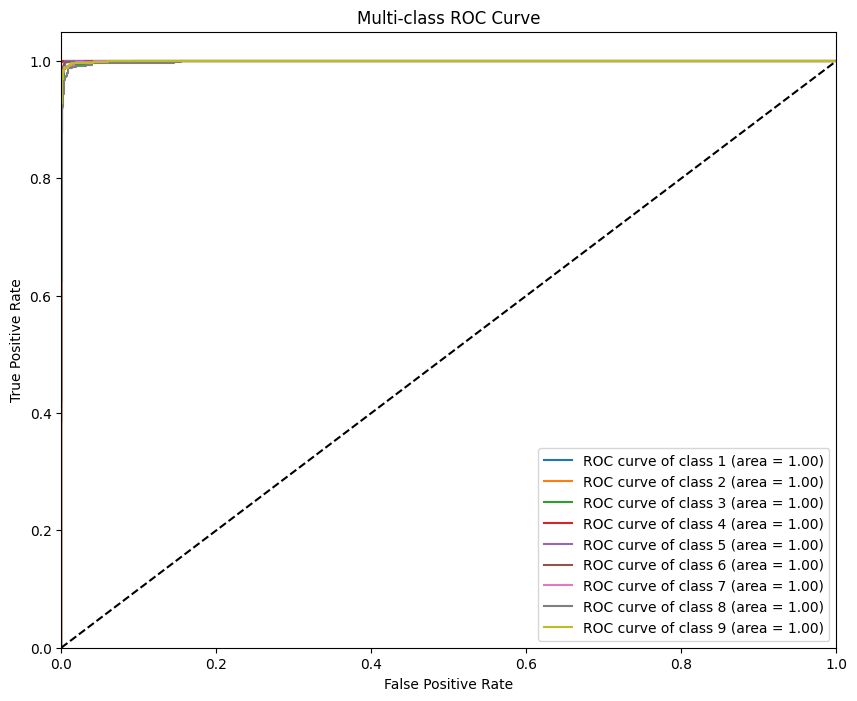

In [32]:
from sklearn.preprocessing import label_binarize

prob_2_array = np.array(prob_2)

y_true_binarized = label_binarize(true_labels_2, classes=np.unique(true_labels_2))

# Расчет ROC-кривой и AUC для каждого класса
n_classes = y_true_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], prob_2_array[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Построение ROC-кривой для каждого класса
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i + 1} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()

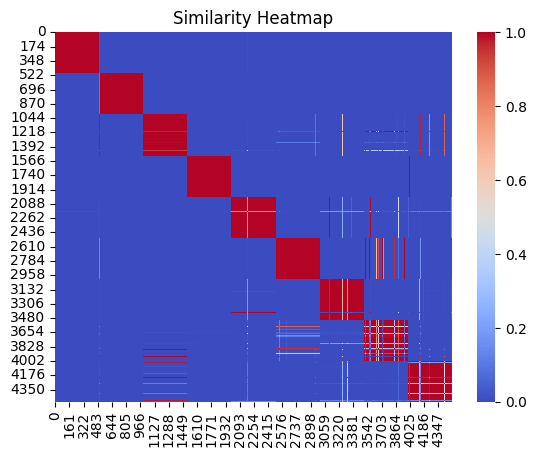

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

# Рассчет схожести между примерами
similarity_matrix = cosine_similarity(prob_2)
sns.heatmap(similarity_matrix, cmap='coolwarm')
plt.title('Similarity Heatmap')
plt.show()

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [ ]:
final_model = Model().to(device)
final_model.load('1-IyWRw2WYwA9lOWb_NsgIZ_taEX_F0py')

d_test_tiny = Dataset('test_tiny')
test_loader_tiny = DataLoader(d_test_tiny, batch_size=32, shuffle=False)

pred = model.test_on_dataset(test_loader_tiny)

Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Loaded pretrained weights for efficientnet-b1
Model loaded from /content/drive/My Drive/problem_1_wsi/best_model.pth


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1SEeXWswVXBUv5aqGZ6u-CHNWZ7-AdGQQ
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 26.5MB/s]


Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.
Batch 1/2: Processed
Batch 2/2: Processed
metrics for test-tiny:
	 accuracy 0.9778:
	 balanced accuracy 0.9778:


Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()

NameError: ignored